The [Heliophysics Application Programmer’s Interface (HAPI)](http://hapi-server.org/) data access specification is a RESTful API and streaming format specification for delivering digital time series data.

HAPI serves time series data in a mission-independent format as a single continous dataset (regardless of mission file formats or file boundaries) from any mission that has implemented a HAPI server.

The first part of this walkthrough has 5 parts:
* [HAPI_01.ipynb - First look at HAPI](HAPI_01.ipynb)
* [HAPI_02.ipynb - Data structures](HAPI_02.ipynb) (this Notebook)
* [HAPI_03.ipynb - Plotting, Pandas, and metadata](HAPI_03.ipynb)
* [HAPI_04.ipynb - Data fusion using HAPI](HAPI_04.ipynb)
* [HAPI_05.ipynb - The HAPI ecosystem](HAPI_05.ipynb)

For more information on HAPI-related software, see http://hapi-server.org/.

In [1]:
# Here we set up our Python environment for this Notebook
from hapiclient import hapi
from hapiplot import hapiplot
%matplotlib inline 
%config InlineBackend.figure_formats = ['svg']
# Show plots in page instead of opening a window
import warnings
warnings.simplefilter("ignore", ResourceWarning) # removes spurious Notebook warns

# Data Model

A request for data of the form
```
data, meta = hapi(server, dataset, parameters, start, stop)
```
returns the [Numpy N-D array](https://docs.scipy.org/doc/numpy-1.15.1/user/quickstart.html) `data` and a Python dictionary `meta` from a HAPI-compliant data server `server`. The structure of `meta` mirrors the structure of the metadata response from a HAPI server.

The basic data structure returned by all HAPI servers is a CSV file in which the first column is a time stamp and subsequent columns are data measured or associated with that time stamp. The columns are mapped to one or more parameters (that may be multi-dimensional arrays) using the metadata associated with the request for CSV data.

For more information on the HAPI server specification, see https://github.com/hapi-server/data-specification. Note that `hapiclient` requests HAPI Binary from a server if that feature is available; a HAPI compliant server is only required to serve HAPI CSV.

## Extracting Data

In [8]:
from hapiclient import hapi

server     = 'http://hapi-server.org/servers/TestData2.0/hapi'
dataset    = 'dataset1'
parameters = 'scalar,vector'
start      = '1970-01-01T00:00:00'
stop       = '1970-01-01T00:00:10'

data,meta = hapi(server,dataset,parameters,start,stop)

`data` is a Numpy N-D array with named fields `Time`, `scalar`, and `vector`. The array has 10 elements (one for each time value) and each element is a list.

In [9]:
data

array([(b'1970-01-01T00:00:00.000Z', 0.        , [ 0.        , -0.70710678, -1.        ]),
       (b'1970-01-01T00:00:01.000Z', 0.00523596, [ 0.00523596, -0.7033947 , -0.99998629]),
       (b'1970-01-01T00:00:02.000Z', 0.01047178, [ 0.01047178, -0.69966334, -0.99994517]),
       (b'1970-01-01T00:00:03.000Z', 0.01570732, [ 0.01570732, -0.6959128 , -0.99987663]),
       (b'1970-01-01T00:00:04.000Z', 0.02094242, [ 0.02094242, -0.69214317, -0.99978068]),
       (b'1970-01-01T00:00:05.000Z', 0.02617695, [ 0.02617695, -0.68835458, -0.99965732]),
       (b'1970-01-01T00:00:06.000Z', 0.03141076, [ 0.03141076, -0.68454711, -0.99950656]),
       (b'1970-01-01T00:00:07.000Z', 0.03664371, [ 0.03664371, -0.68072087, -0.99932839]),
       (b'1970-01-01T00:00:08.000Z', 0.04187565, [ 0.04187565, -0.67687597, -0.99912283]),
       (b'1970-01-01T00:00:09.000Z', 0.04710645, [ 0.04710645, -0.67301251, -0.99888987])],
      dtype=[('Time', 'S24'), ('scalar', '<f8'), ('vector', '<f8', (3,))])

Access all values for parameter `Time`

In [10]:
data['Time']

array([b'1970-01-01T00:00:00.000Z', b'1970-01-01T00:00:01.000Z',
       b'1970-01-01T00:00:02.000Z', b'1970-01-01T00:00:03.000Z',
       b'1970-01-01T00:00:04.000Z', b'1970-01-01T00:00:05.000Z',
       b'1970-01-01T00:00:06.000Z', b'1970-01-01T00:00:07.000Z',
       b'1970-01-01T00:00:08.000Z', b'1970-01-01T00:00:09.000Z'],
      dtype='|S24')

Convert elements of `Time` to Python `datetime` objects

In [11]:
from hapiclient import hapitime2datetime
dateTime = hapitime2datetime(data['Time'])
dateTime

array([datetime.datetime(1970, 1, 1, 0, 0, tzinfo=<UTC>),
       datetime.datetime(1970, 1, 1, 0, 0, 1, tzinfo=<UTC>),
       datetime.datetime(1970, 1, 1, 0, 0, 2, tzinfo=<UTC>),
       datetime.datetime(1970, 1, 1, 0, 0, 3, tzinfo=<UTC>),
       datetime.datetime(1970, 1, 1, 0, 0, 4, tzinfo=<UTC>),
       datetime.datetime(1970, 1, 1, 0, 0, 5, tzinfo=<UTC>),
       datetime.datetime(1970, 1, 1, 0, 0, 6, tzinfo=<UTC>),
       datetime.datetime(1970, 1, 1, 0, 0, 7, tzinfo=<UTC>),
       datetime.datetime(1970, 1, 1, 0, 0, 8, tzinfo=<UTC>),
       datetime.datetime(1970, 1, 1, 0, 0, 9, tzinfo=<UTC>)], dtype=object)

Access all values for parameter `vector`

In [12]:
data['vector']

array([[ 0.        , -0.70710678, -1.        ],
       [ 0.00523596, -0.7033947 , -0.99998629],
       [ 0.01047178, -0.69966334, -0.99994517],
       [ 0.01570732, -0.6959128 , -0.99987663],
       [ 0.02094242, -0.69214317, -0.99978068],
       [ 0.02617695, -0.68835458, -0.99965732],
       [ 0.03141076, -0.68454711, -0.99950656],
       [ 0.03664371, -0.68072087, -0.99932839],
       [ 0.04187565, -0.67687597, -0.99912283],
       [ 0.04710645, -0.67301251, -0.99888987]])

Access first element (all parameters at first time)

In [13]:
data[0]

(b'1970-01-01T00:00:00.000Z', 0., [ 0.        , -0.70710678, -1.        ])

Access value of `vector` at second timestep.

In [14]:
data['vector'][1] 

array([ 0.00523596, -0.7033947 , -0.99998629])

Access value of second component of `vector` at second timestep

In [15]:
data['vector'][1,1]

-0.7033947028105039

## Time Representation

A HAPI-compliant server represents time as an ISO 8601 string (with several constraints - see the [HAPI specification](https://github.com/hapi-server/data-specification/blob/master/hapi-dev/HAPI-data-access-spec-dev.md#representation-of-time)). `hapi.py` reads these into a NumPy array of [Python byte literals](https://stackoverflow.com/a/6273618). To convert byte literals to Python `datetime` objects, the function [`hapitime2datetime`](https://github.com/hapi-server/client-python/blob/master/hapiclient/hapi.py) can be used. Internally, this function uses `pandas.to_datetime` for parsing if possible. Otherwise it falls back to a manual method for parsing. The byte literals can also be converted to Astropy time objects as shown below.

In [16]:
from hapiclient import hapi
from hapiclient import hapitime2datetime

server     = 'http://hapi-server.org/servers/TestData2.0/hapi'
dataset    = 'dataset1'
parameters = 'scalar,vector'
start      = '1970-01-01T00:00:00'
stop       = '1970-01-01T00:00:10'

data, meta = hapi(server, dataset, parameters, start, stop)

In [17]:
data['Time']

array([b'1970-01-01T00:00:00.000Z', b'1970-01-01T00:00:01.000Z',
       b'1970-01-01T00:00:02.000Z', b'1970-01-01T00:00:03.000Z',
       b'1970-01-01T00:00:04.000Z', b'1970-01-01T00:00:05.000Z',
       b'1970-01-01T00:00:06.000Z', b'1970-01-01T00:00:07.000Z',
       b'1970-01-01T00:00:08.000Z', b'1970-01-01T00:00:09.000Z'],
      dtype='|S24')

In [18]:
hapitime2datetime(data['Time'])

array([datetime.datetime(1970, 1, 1, 0, 0, tzinfo=<UTC>),
       datetime.datetime(1970, 1, 1, 0, 0, 1, tzinfo=<UTC>),
       datetime.datetime(1970, 1, 1, 0, 0, 2, tzinfo=<UTC>),
       datetime.datetime(1970, 1, 1, 0, 0, 3, tzinfo=<UTC>),
       datetime.datetime(1970, 1, 1, 0, 0, 4, tzinfo=<UTC>),
       datetime.datetime(1970, 1, 1, 0, 0, 5, tzinfo=<UTC>),
       datetime.datetime(1970, 1, 1, 0, 0, 6, tzinfo=<UTC>),
       datetime.datetime(1970, 1, 1, 0, 0, 7, tzinfo=<UTC>),
       datetime.datetime(1970, 1, 1, 0, 0, 8, tzinfo=<UTC>),
       datetime.datetime(1970, 1, 1, 0, 0, 9, tzinfo=<UTC>)], dtype=object)

In [19]:
!pip install astropy
from astropy.time import Time
Time(data['Time'])

<Time object: scale='utc' format='isot' value=['1970-01-01T00:00:00.000' '1970-01-01T00:00:01.000'
 '1970-01-01T00:00:02.000' '1970-01-01T00:00:03.000'
 '1970-01-01T00:00:04.000' '1970-01-01T00:00:05.000'
 '1970-01-01T00:00:06.000' '1970-01-01T00:00:07.000'
 '1970-01-01T00:00:08.000' '1970-01-01T00:00:09.000']>

## Convert to Pandas DataFrame
As HAPI data are numpy arrays, conversion to Pandas DataFrames uses the existing 'pandas.DataFrame' function.

In [20]:
# Get data for use below
from hapiclient import hapi
from hapiclient import hapitime2datetime

server     = 'http://hapi-server.org/servers/TestData2.0/hapi'
dataset    = 'dataset1'
parameters = 'scalar,vector'
start      = '1970-01-01T00:00:00'
stop       = '1970-01-01T00:00:10'

data, meta = hapi(server,dataset,parameters,start,stop)

import pandas

df_Time = pandas.DataFrame(hapitime2datetime(data['Time']))
df_scalar = pandas.DataFrame(data['scalar'])
df_vector = pandas.DataFrame(data['vector'])

# Create DataFrame
df = pandas.DataFrame()

# Combine DataFrame
df = pandas.concat([df_Time, df_scalar, df_vector], axis=1)

# Name columns
df.columns = ['Time', 'scalar','vector_x', 'vector_y', 'vector_z']

# Set Time to be index
df.set_index('Time', inplace=True)

df

,scalar,vector_x,vector_y,vector_z
Time,,,,
1970-01-01 00:00:00+00:00,0.000000,0.000000,-0.707107,-1.000000
1970-01-01 00:00:01+00:00,0.005236,0.005236,-0.703395,-0.999986
1970-01-01 00:00:02+00:00,0.010472,0.010472,-0.699663,-0.999945
1970-01-01 00:00:03+00:00,0.015707,0.015707,-0.695913,-0.999877
1970-01-01 00:00:04+00:00,0.020942,0.020942,-0.692143,-0.999781
1970-01-01 00:00:05+00:00,0.026177,0.026177,-0.688355,-0.999657
1970-01-01 00:00:06+00:00,0.031411,0.031411,-0.684547,-0.999507
1970-01-01 00:00:07+00:00,0.036644,0.036644,-0.680721,-0.999328
1970-01-01 00:00:08+00:00,0.041876,0.041876,-0.676876,-0.999123


## Convert to AstroPy NDArray 

Conversion from HAPI's numpy data arrays to AstroPy's NDArray is easiest with the ndcube.NDCube function.  We also set a WCS array, and create appropraite timestamps.

In [1]:
from hapiclient import hapi
from hapiclient import hapitime2datetime

server     = 'http://hapi-server.org/servers/TestData2.0/hapi'
dataset    = 'dataset1'
parameters = 'scalar,vector'
start      = '1970-01-01T00:00:00'
stop       = '1970-01-01T00:00:10'

data, meta = hapi(server, dataset, parameters, start, stop)

dateTimes = hapitime2datetime(data['Time'])

from datetime import timezone
times = [dt.replace(tzinfo=timezone.utc).timestamp() for dt in dateTimes]

import astropy.wcs
import astropy.units as u
import numpy as np

!pip install ndcube
import ndcube

my_wcs = astropy.wcs.WCS({"CTYPE1": "TIME", 
                          "CUNIT1": "s", 
                          "CDELT1": 1, 
                          "CRPIX1": 0, 
                          "CRVAL1": 0, 
                          "NAXIS1": 10})

#extra_coords = [("time", 0, dateTimes)]
# latest ndcube changed the extra_coords option
#cube = ndcube.NDCube(data['scalar'], my_wcs, extra_coords=extra_coords)
cube = ndcube.NDCube(data['scalar'], my_wcs)

from astropy.time import Time
t=Time(dateTimes)
cube.extra_coords.add('time',0,t)

cube

     |████████████████████████████████| 108 kB 26.4 MB/s eta 0:00:01
     |████████████████████████████████| 104 kB 70.4 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 60 kB 11.1 MB/s eta 0:00:01
     |████████████████████████████████| 402 kB 81.9 MB/s eta 0:00:01
     |████████████████████████████████| 68 kB 11.1 MB/s eta 0:00:01
     |████████████████████████████████| 191 kB 81.3 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for asdf-coordinates-schemas: filename=asdf_coordinates_schemas-0.1.0-py3-none-any.whl size=19013 sha256=18a0bd0b338befce88fabeee349ea304ca59645006004b0cc080b800931d202d
  Stored in directory: /home/jovyan/.cache/pip/wheels/d2/ec/e5/fa0a97eac37491832995f130264c88aa8e1033689e4cb5211f
  Created wheel for asdf-wcs-schemas

NDCube
------
Dimensions: [10.] pix
Physical Types of Axes: [('time', 'time')]
Unit: None
Data Type: float64

## Generating Data (optional)

For testing, it may be useful to create a simulated HAPI data respsonse in Python. A HAPI response of

```
1970-01-01T00:00:00.000Z, 1.,2.,3.
1970-01-01T00:00:02.000Z, 4.,5.,6.
```

where the metadata indicates there is one parameter named `vector` with `size=[3]` and `type=double` could be created by

In [22]:
import numpy as np
data = np.ndarray(shape=(2), dtype=[('Time', 'S24'), ('vector', '<f8', (3,))])

# Populate: method 1
data['Time'] = np.array([b'1970-01-01T00:00:00.000Z', b'1970-01-01T00:00:01.000Z'])
data['vector'] = np.array([[1.0,2.0,3.0],[4.0,5.0,6.0]])

# Populate: method 2
data[0] = (b'1970-01-01T00:00:00.000Z', [1.0,2.0,3.0])
data[1] = (b'1970-01-01T00:00:01.000Z', [4.0,5.0,6.0])

data

array([(b'1970-01-01T00:00:00.000Z', [1., 2., 3.]),
       (b'1970-01-01T00:00:01.000Z', [4., 5., 6.])],
      dtype=[('Time', 'S24'), ('vector', '<f8', (3,))])

A HAPI response of

```
1970-01-01T00:00:00.000Z, 1.,2.,3.,4.,5.,6.,7.,8.,9.
1970-01-01T00:00:02.000Z, 11.,12.,13.,14.,15.,16.,17.,18.,19.
```
where the metadata indicates there is one parameter named `matrix` with `size=[3,3]` and `type=double` could be created by

In [23]:
import numpy as np

# Allocate
data = np.ndarray(shape=(2), dtype=[('Time', 'S24'), ('matrix', '<f8', (3,3,))])

# Populate
data['Time'] = np.array([b'1970-01-01T00:00:00.000Z', b'1970-01-01T00:00:01.000Z'])
data['matrix'] = np.array( [ [[1.0,2.0,3.0],[4.0,5.0,6.0],[7.0,8.0,9.0]], [[11.0,12.0,13.0],[14.0,15.0,16.0],[17.0,18.0,19.0]]] )

data

array([(b'1970-01-01T00:00:00.000Z', [[ 1.,  2.,  3.], [ 4.,  5.,  6.], [ 7.,  8.,  9.]]),
       (b'1970-01-01T00:00:01.000Z', [[11., 12., 13.], [14., 15., 16.], [17., 18., 19.]])],
      dtype=[('Time', 'S24'), ('matrix', '<f8', (3, 3))])

Multiple parameters, e.g. a response with both the vector and matrix parameters considered above

```
1970-01-01T00:00:00.000Z, 1.,2.,3.,  1.,2.,3.,4.,5.,6.,7.,8.,9.
1970-01-01T00:00:02.000Z, 4.,5.,6., 11.,12.,13.,14.,15.,16.,17.,18.,19.
```

can be created by populating

In [24]:
data = np.ndarray(shape=(2), dtype=[('Time', 'S24'), ('vector', '<f8', (3,)), ('matrix', '<f8', (3,3,))])
data['Time'] = np.array([b'1970-01-01T00:00:00.000Z', b'1970-01-01T00:00:01.000Z'])
data['vector'] = np.array([[1.0,2.0,3.0],[4.0,5.0,6.0]])
data['matrix'] = np.array( [ [[1.0,2.0,3.0],[4.0,5.0,6.0],[7.0,8.0,9.0]], [[11.0,12.0,13.0],[14.0,15.0,16.0],[17.0,18.0,19.0]]] )
data

array([(b'1970-01-01T00:00:00.000Z', [1., 2., 3.], [[ 1.,  2.,  3.], [ 4.,  5.,  6.], [ 7.,  8.,  9.]]),
       (b'1970-01-01T00:00:01.000Z', [4., 5., 6.], [[11., 12., 13.], [14., 15., 16.], [17., 18., 19.]])],
      dtype=[('Time', 'S24'), ('vector', '<f8', (3,)), ('matrix', '<f8', (3, 3))])

# Plotting

## hapiplot

The HAPI Python client package comes with a simple plotting function `hapiplot` that plots all of the requested variables.

Interally, `hapiplot` uses Matplotlib and the functions `timeseries.py` and  `heatmap.py` in the directory [plot](https://github.com/hapi-server/client-python/tree/master/hapiclient/plot). `hapiplot` plots all of the parameters returned by a call to `hapi` and forms calls to `timeseries.py` and  `heatmap.py` with labels extracted from `meta`.

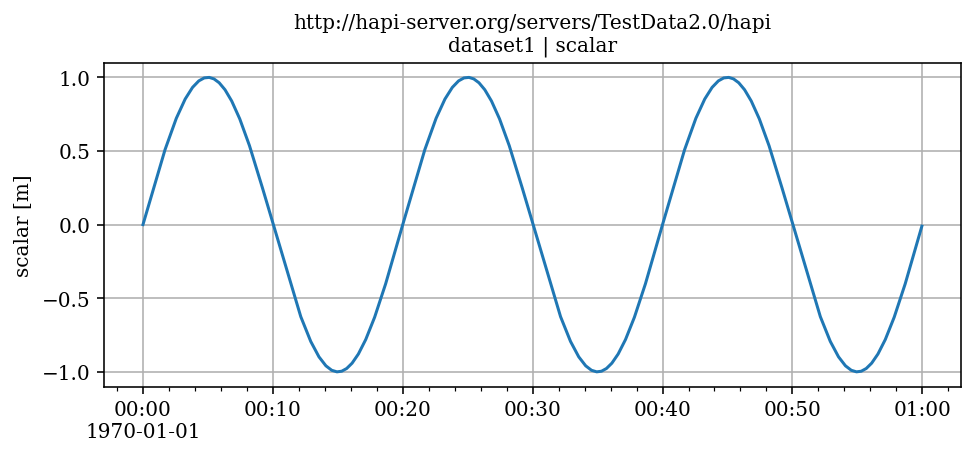

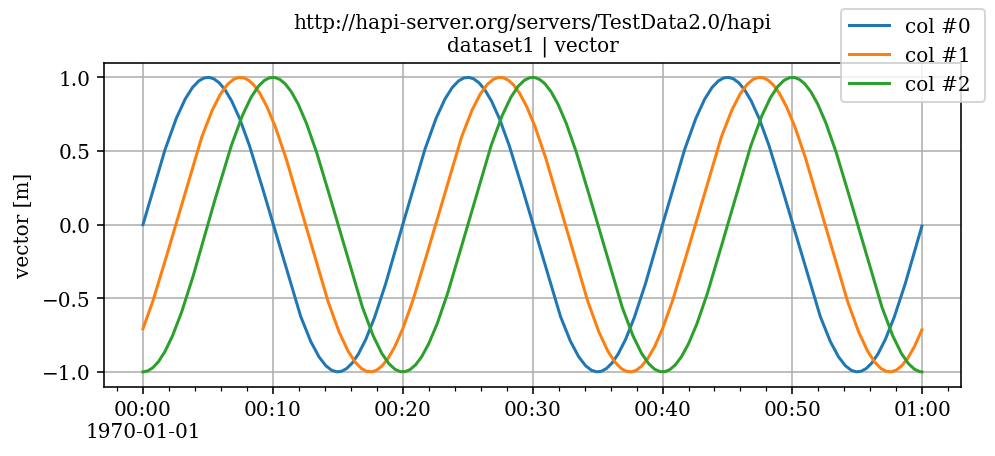

In [2]:
# Get data for use below
from hapiplot import hapiplot

server     = 'http://hapi-server.org/servers/TestData2.0/hapi'
dataset    = 'dataset1'
parameters = 'scalar,vector'
start      = '1970-01-01T00:00:00'
stop       = '1970-01-01T00:59:59'

status=hapiplot(server, dataset, parameters, start, stop)

# or, get data and pass to hapiplot():
#
# from hapiclient.hapi import hapi
# data,meta = hapi(server,dataset,parameters,start,stop)
# hapiplot(data, meta)

## Additional plotting tools for non-Jupyter use (optional)
'hapiplot' also incldues its own optional 'hapiplotserver' as well as a server driver for the AutoPlot package.

## PySPEDAS/PyTplot
Users of PySPEDAS can access HAPI servers and manipulate the data directly from the 'pyspedas' package, without having to load 'hapiclient'

Loading SW_P_Den
Loading SW_V


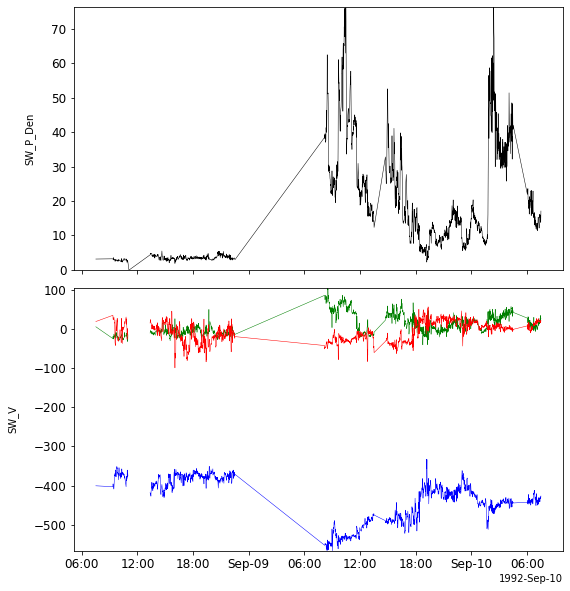

In [4]:
#!pip install pyspedas --upgrade

from pyspedas.hapi.hapi import hapi as pyhapi

server     = 'https://cdaweb.gsfc.nasa.gov/hapi'
dataset    = 'GE_K0_CPI'
parameters = 'SW_P_Den,SW_V'
start      = '1992-09-08T07:30:40Z'
stop       = '1992-09-10T07:30:40.000Z'
x = pyhapi(trange=[start, stop], server=server, dataset=dataset, parameters=parameters)

from pytplot import tplot
tplot(x)

----
Next up, a deeper look at [plotting, pandas, and metadata](HAPI_03.ipynb)
----